<a href="https://colab.research.google.com/github/alaki22/Contacts/blob/main/model_experiment_N-BEATS2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Downloading Kaggle data sets directly into Colab**

Install the kaggle python library

In [1]:
! pip install kaggle

Mount the Google drive so you can store your kaggle API credentials for future use

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Make a directory for kaggle at the temporary instance location on Colab drive.

Download your kaggle API key (.json file). You can do this by going to your kaggle account page and clicking 'Create new API token' under the API section.

In [3]:
! mkdir ~/.kaggle

Upload the json file to Google Drive and then copy to the temporary location.

In [4]:
!cp /content/drive/MyDrive/ColabNotebooks/kaggle_API_credentials/kaggle.json ~/.kaggle/kaggle.json

Change the file permissions to read/write to the owner only

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

**Competitions and Datasets are the two types of Kaggle data**

**1. Download competition data**

If you get 403 Forbidden error, you need to click 'Late Submission' on the Kaggle page for that competition.

In [6]:
! kaggle competitions download -c walmart-recruiting-store-sales-forecasting

  0% 0.00/2.70M [00:00<?, ?B/s]
100% 2.70M/2.70M [00:00<00:00, 145MB/s]


Unzip, in case the downloaded file is zipped. Refresh the files on the left hand side to update the view.

In [7]:
! unzip walmart-recruiting-store-sales-forecasting

Archive:  walmart-recruiting-store-sales-forecasting.zip
  inflating: features.csv.zip        
  inflating: sampleSubmission.csv.zip  
  inflating: stores.csv              
  inflating: test.csv.zip            
  inflating: train.csv.zip           


In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import gc # For garbage collection
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.expand_frame_repr', False)

In [9]:
stores = pd.read_csv('stores.csv')
train = pd.read_csv("train.csv.zip")
features = pd.read_csv('features.csv.zip')
sample = pd.read_csv('sampleSubmission.csv.zip')
test = pd.read_csv('test.csv.zip')

In [10]:
# Convert 'Date' columns to datetime objects for easier manipulation
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])
features['Date'] = pd.to_datetime(features['Date'])

# Merge features with train and test data.
# Note: 'IsHoliday' is present in both train/test and features.csv.
# We'll merge on it to ensure consistency, but if there were discrepancies,
# we'd need a more careful merge strategy.
train_df = pd.merge(train, features, on=['Store', 'Date', 'IsHoliday'], how='left')
test_df = pd.merge(test, features, on=['Store', 'Date', 'IsHoliday'], how='left')

# Merge store information
train_df = pd.merge(train_df, stores, on='Store', how='left')
test_df = pd.merge(test_df, stores, on='Store', how='left')

print("\n--- Merged Train Data Head ---")
print(train_df.head())
print("\n--- Merged Test Data Head ---")
print(test_df.head())

print("\n--- Merged Train Data Info ---")
print(train_df.info())
print("\n--- Merged Test Data Info ---")
print(test_df.info())

# Free up memory
del train, test, features, stores
gc.collect()


--- Merged Train Data Head ---
   Store  Dept       Date  Weekly_Sales  IsHoliday  Temperature  Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment Type    Size
0      1     1 2010-02-05      24924.50      False        42.31       2.572        NaN        NaN        NaN        NaN        NaN  211.096358         8.106    A  151315
1      1     1 2010-02-12      46039.49       True        38.51       2.548        NaN        NaN        NaN        NaN        NaN  211.242170         8.106    A  151315
2      1     1 2010-02-19      41595.55      False        39.93       2.514        NaN        NaN        NaN        NaN        NaN  211.289143         8.106    A  151315
3      1     1 2010-02-26      19403.54      False        46.63       2.561        NaN        NaN        NaN        NaN        NaN  211.319643         8.106    A  151315
4      1     1 2010-03-05      21827.90      False        46.50       2.625        NaN        NaN        NaN        Na

0

In [11]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.base import BaseEstimator, TransformerMixin
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [13]:
class WalmartDataset(Dataset):
    def __init__(self, sequences, targets, weights=None):
        self.sequences = torch.FloatTensor(sequences)
        self.targets = torch.FloatTensor(targets)
        self.weights = torch.FloatTensor(weights) if weights is not None else None

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        if self.weights is not None:
            return self.sequences[idx], self.targets[idx], self.weights[idx]
        return self.sequences[idx], self.targets[idx]

In [14]:
class TrendBasis(nn.Module):
    def __init__(self, theta_size, target_size):
        super().__init__()
        self.theta_size = theta_size
        self.target_size = target_size

    def forward(self, theta):
        batch_size = theta.shape[0]
        t = torch.linspace(0, 1, self.target_size, device=theta.device)
        t = t.unsqueeze(0).expand(batch_size, -1)

        powers = torch.arange(self.theta_size, device=theta.device).float()
        T = t.unsqueeze(-1) ** powers.unsqueeze(0).unsqueeze(0)

        result = torch.sum(theta.unsqueeze(1) * T, dim=-1)
        return result

In [15]:
class SeasonalityBasis(nn.Module):
    def __init__(self, theta_size, target_size):
        super().__init__()
        self.theta_size = theta_size
        self.target_size = target_size

    def forward(self, theta):
        batch_size = theta.shape[0]
        t = torch.linspace(0, 1, self.target_size, device=theta.device)
        t = t.unsqueeze(0).expand(batch_size, -1)

        basis_functions = []
        for i in range(self.theta_size // 2):
            freq = i + 1
            basis_functions.append(torch.cos(2 * np.pi * freq * t))
            basis_functions.append(torch.sin(2 * np.pi * freq * t))

        if self.theta_size % 2 == 1:
            basis_functions.append(torch.ones_like(t))

        basis = torch.stack(basis_functions[:self.theta_size], dim=-1)
        result = torch.sum(theta.unsqueeze(1) * basis, dim=-1)
        return result

In [16]:
class NBeatsBlock(nn.Module):
    def __init__(self, input_size, theta_size, basis_function, layers, layer_size,
                 num_features, forecast_size=1):
        super().__init__()
        self.input_size = input_size
        self.theta_size = theta_size
        self.basis_function = basis_function
        self.num_features = num_features
        self.forecast_size = forecast_size

        input_dim = input_size * num_features

        layers_list = []
        layers_list.append(nn.Linear(input_dim, layer_size))
        layers_list.append(nn.ReLU())

        for _ in range(layers - 1):
            layers_list.append(nn.Linear(layer_size, layer_size))
            layers_list.append(nn.ReLU())

        layers_list.append(nn.Dropout(0.1))
        self.fc_stack = nn.Sequential(*layers_list)

        self.theta_layer = nn.Linear(layer_size, theta_size)

        if basis_function == 'generic':
            self.backcast_basis = nn.Linear(theta_size, input_dim)
            self.forecast_basis = nn.Linear(theta_size, forecast_size)
        elif basis_function == 'trend':
            self.backcast_basis = TrendBasis(theta_size, input_size)
            self.forecast_basis = TrendBasis(theta_size, forecast_size)
        elif basis_function == 'seasonality':
            self.backcast_basis = SeasonalityBasis(theta_size, input_size)
            self.forecast_basis = SeasonalityBasis(theta_size, forecast_size)

    def forward(self, x):
        batch_size = x.shape[0]
        x_flat = x.view(batch_size, -1)

        h = self.fc_stack(x_flat)
        theta = self.theta_layer(h)

        if self.basis_function == 'generic':
            backcast = self.backcast_basis(theta)
            forecast = self.forecast_basis(theta)
            backcast = backcast.view(batch_size, self.input_size, self.num_features)
        else:
            backcast = self.backcast_basis(theta)
            forecast = self.forecast_basis(theta)
            backcast = backcast.unsqueeze(-1).expand(-1, -1, self.num_features)

        return backcast, forecast.squeeze(-1)

In [17]:
class NBeatsNet(nn.Module):
    def __init__(self, input_size, num_features, forecast_size=1,
                 stacks=2, blocks_per_stack=3, layers=4, layer_size=512, theta_size=32):
        super().__init__()
        self.input_size = input_size
        self.num_features = num_features
        self.forecast_size = forecast_size
        self.stacks = stacks
        self.blocks_per_stack = blocks_per_stack

        stack_types = ['trend', 'seasonality'] + ['generic'] * (stacks - 2)
        if stacks <= 2:
            stack_types = ['generic'] * stacks

        self.blocks = nn.ModuleList()
        for stack_idx in range(stacks):
            basis_function = stack_types[stack_idx] if stack_idx < len(stack_types) else 'generic'

            for block_idx in range(blocks_per_stack):
                block = NBeatsBlock(
                    input_size=input_size,
                    theta_size=theta_size,
                    basis_function=basis_function,
                    layers=layers,
                    layer_size=layer_size,
                    num_features=num_features,
                    forecast_size=forecast_size
                )
                self.blocks.append(block)

    def forward(self, x):
        batch_size = x.shape[0]
        residual = x
        forecast = torch.zeros(batch_size, self.forecast_size, device=x.device)

        for block in self.blocks:
            backcast, block_forecast = block(residual)
            residual = residual - backcast
            forecast = forecast + block_forecast

        return forecast

In [18]:
class MissingValueImputer(BaseEstimator, TransformerMixin):
    """
    Custom Transformer to handle missing values for specific columns.
    - MarkDown columns: fill with 0.
    - Other specified numerical columns: fill with ffill then bfill, fallback to mean.
    """
    def __init__(self, markdown_cols=None, numerical_cols_to_impute=None):
        self.markdown_cols = markdown_cols if markdown_cols is not None else [f'MarkDown{i}' for i in range(1, 6)]
        self.numerical_cols_to_impute = numerical_cols_to_impute if numerical_cols_to_impute is not None else ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
        self.means = {} # To store means for fallback imputation during transform

    def fit(self, X, y=None):
        # Calculate means for fallback imputation from the training data
        for col in self.numerical_cols_to_impute:
            if col in X.columns:
                self.means[col] = X[col].mean()
        return self

    def transform(self, X):
        X_copy = X.copy()


        for col in self.markdown_cols:
          if col in X_copy.columns:
            X_copy[f"{col}_was_missing"] = X_copy[col].isna().astype(int)
            X_copy[col] = X_copy[col].fillna(0)


        # Impute other numerical columns with ffill then bfill, fallback to mean
        for col in self.numerical_cols_to_impute:
            if col in X_copy.columns:
                X_copy[col] = X_copy[col].fillna(method='ffill').fillna(method='bfill')
                # Fallback to mean if NaNs still exist (e.g., if all values were NaN in a column)
                if X_copy[col].isnull().any() and col in self.means:
                    X_copy[col] = X_copy[col].fillna(self.means[col])
        return X_copy

In [19]:
class NBEATSLabelEncoder(BaseEstimator, TransformerMixin):
    """
    Custom Transformer to encode categorical features.
    N-BEATS works better with label-encoded categoricals than pandas categories.
    """
    def __init__(self, categorical_cols=None):
        self.categorical_cols = categorical_cols if categorical_cols is not None else ['Store', 'Dept', 'Type']
        self.label_encoders = {}

    def fit(self, X, y=None):
        for col in self.categorical_cols:
            if col in X.columns:
                self.label_encoders[col] = LabelEncoder()
                self.label_encoders[col].fit(X[col].astype(str))
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col in self.categorical_cols:
            if col in X_copy.columns and col in self.label_encoders:
                # Handle unseen categories by using a default value
                X_copy[col] = X_copy[col].astype(str)
                known_categories = set(self.label_encoders[col].classes_)
                X_copy[col] = X_copy[col].apply(lambda x: x if x in known_categories else 'unknown')

                # Add 'unknown' to encoder if needed
                if 'unknown' not in self.label_encoders[col].classes_:
                    current_classes = list(self.label_encoders[col].classes_)
                    current_classes.append('unknown')
                    self.label_encoders[col].classes_ = np.array(current_classes)

                X_copy[col] = self.label_encoders[col].transform(X_copy[col])
        return X_copy

In [20]:
def create_time_features(df):
    """Create time-based features"""
    df = df.copy()
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Week'] = df['Date'].dt.isocalendar().week
    df['DayOfYear'] = df['Date'].dt.dayofyear
    df['IsHoliday'] = df['IsHoliday'].astype(int)

    # Cyclical encoding for month and week
    df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
    df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
    df['Week_sin'] = np.sin(2 * np.pi * df['Week'] / 52)
    df['Week_cos'] = np.cos(2 * np.pi * df['Week'] / 52)

    return df

In [21]:

def prepare_sequences_per_store_dept(df, lookback_window=12, forecast_horizon=1):
    """
    Prepare sequences for each store-department combination
    """
    sequences = []
    targets = []
    weights = []
    store_dept_info = []

    # Get unique store-department combinations
    store_dept_combinations = df[['Store', 'Dept']].drop_duplicates()

    for _, row in store_dept_combinations.iterrows():
        store_id = row['Store']
        dept_id = row['Dept']
        print(f"creating sequences for store {store_id} and department {dept_id}")
        # Get data for this store-department combination
        store_dept_data = df[(df['Store'] == store_id) & (df['Dept'] == dept_id)].copy()
        store_dept_data = store_dept_data.sort_values('Date')

        # Skip if not enough data
        if len(store_dept_data) < lookback_window + forecast_horizon:
            continue

        # Extract features and target
        feature_cols = ['Weekly_Sales', 'IsHoliday', 'Temperature', 'Fuel_Price',
                       'CPI', 'Unemployment', 'Month_sin', 'Month_cos',
                       'Week_sin', 'Week_cos', 'Size']

        # Add MarkDown features if they exist
        markdown_cols = [col for col in store_dept_data.columns if col.startswith('MarkDown')]
        feature_cols.extend(markdown_cols)

        # Fill missing values
        # for col in feature_cols:
        #     if col in store_dept_data.columns:
        #         if col.startswith('MarkDown'):
        #             store_dept_data[col] = store_dept_data[col].fillna(0)
        #         else:
        #             store_dept_data[col] = store_dept_data[col].fillna(method='ffill').fillna(method='bfill')

        # Create sequences
        for i in range(len(store_dept_data) - lookback_window - forecast_horizon + 1):

            # Input sequence
            sequence = store_dept_data.iloc[i:i+lookback_window][feature_cols].values

            # Target (next week's sales)
            target = store_dept_data.iloc[i+lookback_window]['Weekly_Sales']

            # Weight (holiday weight)
            weight = 5 if store_dept_data.iloc[i+lookback_window]['IsHoliday'] == 1 else 1

            sequences.append(sequence)
            targets.append(target)
            weights.append(weight)
            store_dept_info.append((store_id, dept_id))

    return np.array(sequences), np.array(targets), np.array(weights), store_dept_info

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Apply time features
train_df = create_time_features(train_df)
test_df = create_time_features(test_df)

# Debug: Check date range in your data
print("Date range in training data:")
print(f"Min date: {train_df['Date'].min()}")
print(f"Max date: {train_df['Date'].max()}")
print(f"Total samples: {len(train_df)}")

# Apply preprocessing pipeline
preprocessing_pipeline = Pipeline([
    ('missing_value_imputer', MissingValueImputer()),
    ('label_encoder', NBEATSLabelEncoder())
])

X_train = train_df.drop(['Weekly_Sales'], axis=1)
y_train = train_df['Weekly_Sales']

X_train_processed = preprocessing_pipeline.fit_transform(X_train, y_train)
X_train_processed['Weekly_Sales'] = y_train.values

# Ensure Date column is datetime
if 'Date' not in X_train_processed.columns:
    # If Date was removed during preprocessing, add it back
    X_train_processed['Date'] = train_df['Date'].values
else:
    X_train_processed['Date'] = pd.to_datetime(X_train_processed['Date'])

# Choose validation cutoff based on actual data range
# Use the last 20% of time period for validation
date_range = X_train_processed['Date'].max() - X_train_processed['Date'].min()
validation_cutoff_date = X_train_processed['Date'].max() - pd.Timedelta(days=date_range.days * 0.2)

print(f"\nUsing validation cutoff: {validation_cutoff_date}")

# Split data properly by time
train_data = X_train_processed[X_train_processed['Date'] < validation_cutoff_date].copy()
val_data = X_train_processed[X_train_processed['Date'] >= validation_cutoff_date].copy()

print(f"Training data: {len(train_data)} samples")
print(f"Validation data: {len(val_data)} samples")

# Check if validation data is empty
if len(val_data) == 0:
    print("WARNING: Validation data is empty! Adjusting cutoff date...")
    # Use a more conservative split
    validation_cutoff_date = X_train_processed['Date'].quantile(0.8)
    train_data = X_train_processed[X_train_processed['Date'] < validation_cutoff_date].copy()
    val_data = X_train_processed[X_train_processed['Date'] >= validation_cutoff_date].copy()
    print(f"Adjusted - Training data: {len(train_data)} samples")
    print(f"Adjusted - Validation data: {len(val_data)} samples")

# Create sequences for each dataset
lookback_window = 12  # Reduced from 52 for better performance

print("Creating training sequences...")
train_sequences, train_targets, train_weights, train_info = prepare_sequences_per_store_dept(
    train_data, lookback_window=lookback_window)

print("Creating validation sequences...")
val_sequences, val_targets, val_weights, val_info = prepare_sequences_per_store_dept(
    val_data, lookback_window=lookback_window)

print(f"Training sequences shape: {train_sequences.shape}")
print(f"Validation sequences shape: {val_sequences.shape}")

# Check if sequences are empty before scaling
if train_sequences.size == 0:
    raise ValueError("Training sequences are empty. Check your data preparation.")

if val_sequences.size == 0:
    print("WARNING: Validation sequences are empty. Using a portion of training data for validation.")
    # Alternative: Use sklearn's train_test_split as fallback
    train_sequences, val_sequences, train_targets, val_targets, train_weights, val_weights = train_test_split(
        train_sequences, train_targets, train_weights, test_size=0.2, random_state=42
    )
    print(f"Split training sequences shape: {train_sequences.shape}")
    print(f"Split validation sequences shape: {val_sequences.shape}")

# Normalize the data
scaler = StandardScaler()
train_sequences_scaled = scaler.fit_transform(
    train_sequences.reshape(-1, train_sequences.shape[-1])
).reshape(train_sequences.shape)

val_sequences_scaled = scaler.transform(
    val_sequences.reshape(-1, val_sequences.shape[-1])
).reshape(val_sequences.shape)

# Create datasets
train_dataset = WalmartDataset(train_sequences_scaled, train_targets, train_weights)
val_dataset = WalmartDataset(val_sequences_scaled, val_targets, val_weights)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

print(f"Number of features: {train_sequences.shape[-1]}")
print("Data preparation completed!")

# Additional debugging information
print(f"\nFinal shapes:")
print(f"Train sequences: {train_sequences_scaled.shape}")
print(f"Val sequences: {val_sequences_scaled.shape}")
print(f"Train targets: {train_targets.shape}")
print(f"Val targets: {val_targets.shape}")

Streaming output truncated to the last 5000 lines.
creating sequences for store 12 and department 44
creating sequences for store 12 and department 45
creating sequences for store 12 and department 46
creating sequences for store 12 and department 47
creating sequences for store 12 and department 48
creating sequences for store 12 and department 49
creating sequences for store 12 and department 50
creating sequences for store 12 and department 51
creating sequences for store 12 and department 53
creating sequences for store 12 and department 55
creating sequences for store 12 and department 57
creating sequences for store 12 and department 58
creating sequences for store 12 and department 59
creating sequences for store 12 and department 60
creating sequences for store 12 and department 61
creating sequences for store 12 and department 62
creating sequences for store 12 and department 64
creating sequences for store 12 and department 65
creating sequences for store 12 and department 66

In [25]:
%pip install -q dagshub


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 119.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 7.0 MB/s eta 0:00:00


In [26]:
!pip install mlflow==2.7.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.5/18.5 MB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.3/150.3 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.1/148.1 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.1/96.1 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 MB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.5/506.5 kB 38.2 MB/s eta 0:00:00
  Attempting uninstall: pytz
    Found exist

In [27]:
import dagshub
# Try to get credentials from environment first
dagshub.init(
    repo_owner='abarb22',
    repo_name='Walmart-Recruiting---Store-Sales-Forecasting',
    mlflow=True
)

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=437ab92a-f3ec-4eac-9894-4f5a122237dc&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=ebb34291131cb688c9382c5621d0397ccb324e903402f77c9b0a24e9d0f2fa73




Accessing as alaki22

Initialized MLflow to track repo "abarb22/Walmart-Recruiting---Store-Sales-Forecasting"

Repository abarb22/Walmart-Recruiting---Store-Sales-Forecasting initialized!

In [43]:
class ModelTrainer:
    def __init__(self, model, train_loader, val_loader, sales_mean, sales_std,
                 lr=1e-3, num_epochs=50, use_wmae_loss=True):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.sales_mean = sales_mean
        self.sales_std = sales_std
        self.lr = lr
        self.num_epochs = num_epochs
        self.use_wmae_loss = use_wmae_loss

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        self.criterion = nn.MSELoss()

        # Training history
        self.train_losses = []
        self.val_losses = []
        self.val_wmaes = []

        # Best model tracking
        self.best_wmae = float('inf')
        self.best_epoch = 0
        self.best_model_state = None

    def _wmae_loss(self, predictions, targets, weights):
        """Weighted Mean Absolute Error loss"""
        abs_errors = torch.abs(predictions - targets)
        weighted_errors = weights * abs_errors
        return torch.sum(weighted_errors) / torch.sum(weights)

    def _validate(self):
        """Fixed validation method with proper shape handling"""
        self.model.eval()
        running_val_loss = 0.0
        val_samples = 0

        all_preds = []
        all_targets = []
        all_weights = []

        with torch.no_grad():
            for sequences, targets, weights in self.val_loader:
                sequences = sequences.to(self.device)
                targets = targets.to(self.device)
                weights = weights.to(self.device)

                outputs = self.model(sequences)

                # Debug: Print shapes to understand the issue
                # print(f"Debug - outputs shape: {outputs.shape}, targets shape: {targets.shape}")

                # Ensure outputs match targets shape
                if outputs.dim() > 1:
                    if outputs.shape[1] == 1:
                        outputs = outputs.squeeze(1)  # Remove dimension of size 1
                    else:
                        # If forecast_size > 1, take only the first prediction
                        outputs = outputs[:, 0]

                # Now outputs should be (batch_size,) same as targets
                # print(f"Debug - after reshape: outputs shape: {outputs.shape}, targets shape: {targets.shape}")

                if self.use_wmae_loss:
                    loss = self._wmae_loss(outputs, targets, weights)
                else:
                    loss = self.criterion(outputs, targets)

                running_val_loss += loss.item() * sequences.size(0)
                val_samples += sequences.size(0)

                # Convert to numpy - now all should have same shape
                batch_preds = outputs.cpu().numpy()
                batch_targets = targets.cpu().numpy()
                batch_weights = weights.cpu().numpy()

                # Verify shapes match
                if batch_preds.shape != batch_targets.shape:
                    print(f"Warning: Still have shape mismatch after fix!")
                    print(f"  Preds: {batch_preds.shape}, Targets: {batch_targets.shape}")
                    continue  # Skip this batch

                all_preds.extend(batch_preds)
                all_targets.extend(batch_targets)
                all_weights.extend(batch_weights)

        # Convert to arrays
        all_preds = np.array(all_preds)
        all_targets = np.array(all_targets)
        all_weights = np.array(all_weights)

        val_loss = running_val_loss / val_samples
        val_wmae = self._calculate_wmae(all_preds, all_targets, all_weights)

        return val_loss, val_wmae

    def _calculate_wmae(self, predictions, targets, weights):
        """Calculate weighted MAE with shape validation"""
        # Ensure all arrays have the same shape
        if len(predictions) != len(targets) or len(predictions) != len(weights):
            print(f"Shape mismatch in WMAE calculation:")
            print(f"  Predictions: {predictions.shape}")
            print(f"  Targets: {targets.shape}")
            print(f"  Weights: {weights.shape}")
            # Take minimum length to avoid errors
            min_len = min(len(predictions), len(targets), len(weights))
            predictions = predictions[:min_len]
            targets = targets[:min_len]
            weights = weights[:min_len]

        abs_errors = np.abs(predictions - targets)
        if np.sum(weights) == 0:
            return np.mean(abs_errors)
        return np.sum(weights * abs_errors) / np.sum(weights)

    def train(self):
        """Training loop"""
        print(f"Starting training for {self.num_epochs} epochs...")

        for epoch in range(self.num_epochs):
            # Training phase
            self.model.train()
            running_train_loss = 0.0
            train_samples = 0

            for sequences, targets, weights in self.train_loader:
                sequences = sequences.to(self.device)
                targets = targets.to(self.device)
                weights = weights.to(self.device)

                self.optimizer.zero_grad()
                outputs = self.model(sequences)

                # Apply same shape fixing as in validation
                if outputs.dim() > 1:
                    if outputs.shape[1] == 1:
                        outputs = outputs.squeeze(1)
                    else:
                        outputs = outputs[:, 0]

                if self.use_wmae_loss:
                    loss = self._wmae_loss(outputs, targets, weights)
                else:
                    loss = self.criterion(outputs, targets)

                loss.backward()
                self.optimizer.step()

                running_train_loss += loss.item() * sequences.size(0)
                train_samples += sequences.size(0)

            # Validation phase
            val_loss, val_wmae = self._validate()

            # Record metrics
            epoch_train_loss = running_train_loss / train_samples
            self.train_losses.append(epoch_train_loss)
            self.val_losses.append(val_loss)
            self.val_wmaes.append(val_wmae)

            # Track best model
            if val_wmae < self.best_wmae:
                self.best_wmae = val_wmae
                self.best_epoch = epoch
                self.best_model_state = self.model.state_dict().copy()

            # Print progress
            print(f"Epoch {epoch:3d}: Train Loss: {epoch_train_loss:.4f}, "
                      f"Val Loss: {val_loss:.4f}, Val WMAE: {val_wmae:.4f}")

        # Load best model
        if self.best_model_state is not None:
            self.model.load_state_dict(self.best_model_state)

        print(f"Training completed! Best WMAE: {self.best_wmae:.4f} at epoch {self.best_epoch}")

    def plot_losses(self, save_path=None):
        """Plot training and validation losses"""
        import matplotlib.pyplot as plt

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        # Plot losses
        ax1.plot(self.train_losses, label='Train Loss')
        ax1.plot(self.val_losses, label='Val Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.set_title('Training and Validation Loss')
        ax1.legend()
        ax1.grid(True)

        # Plot WMAE
        ax2.plot(self.val_wmaes, label='Val WMAE', color='red')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('WMAE')
        ax2.set_title('Validation WMAE')
        ax2.legend()
        ax2.grid(True)

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')

        plt.show()

Starting training for 100 epochs...
Epoch   0: Train Loss: 13908.7055, Val Loss: 13643.8392, Val WMAE: 13647.6553
Epoch   1: Train Loss: 13822.8929, Val Loss: 13425.0970, Val WMAE: 13428.7285
Epoch   2: Train Loss: 13799.7818, Val Loss: 13579.8100, Val WMAE: 13583.7324
Epoch   3: Train Loss: 13783.4295, Val Loss: 13758.5000, Val WMAE: 13762.6494
Epoch   4: Train Loss: 13810.9061, Val Loss: 13403.0003, Val WMAE: 13406.5684
Epoch   5: Train Loss: 13795.6302, Val Loss: 13529.9693, Val WMAE: 13533.9219
Epoch   6: Train Loss: 13788.4019, Val Loss: 13626.6369, Val WMAE: 13630.5781
Epoch   7: Train Loss: 13799.5065, Val Loss: 13409.3177, Val WMAE: 13412.9609
Epoch   8: Train Loss: 13789.6161, Val Loss: 13388.7171, Val WMAE: 13392.1934
Epoch   9: Train Loss: 13788.5221, Val Loss: 13526.4264, Val WMAE: 13530.3818
Epoch  10: Train Loss: 13780.1752, Val Loss: 13435.3175, Val WMAE: 13438.9785
Epoch  11: Train Loss: 13779.0897, Val Loss: 13341.9319, Val WMAE: 13345.2305
Epoch  12: Train Loss: 13784

Epoch  99: Train Loss: 13770.3722, Val Loss: 13451.2714, Val WMAE: 13454.9121
Training completed! Best WMAE: 13345.2305 at epoch 11


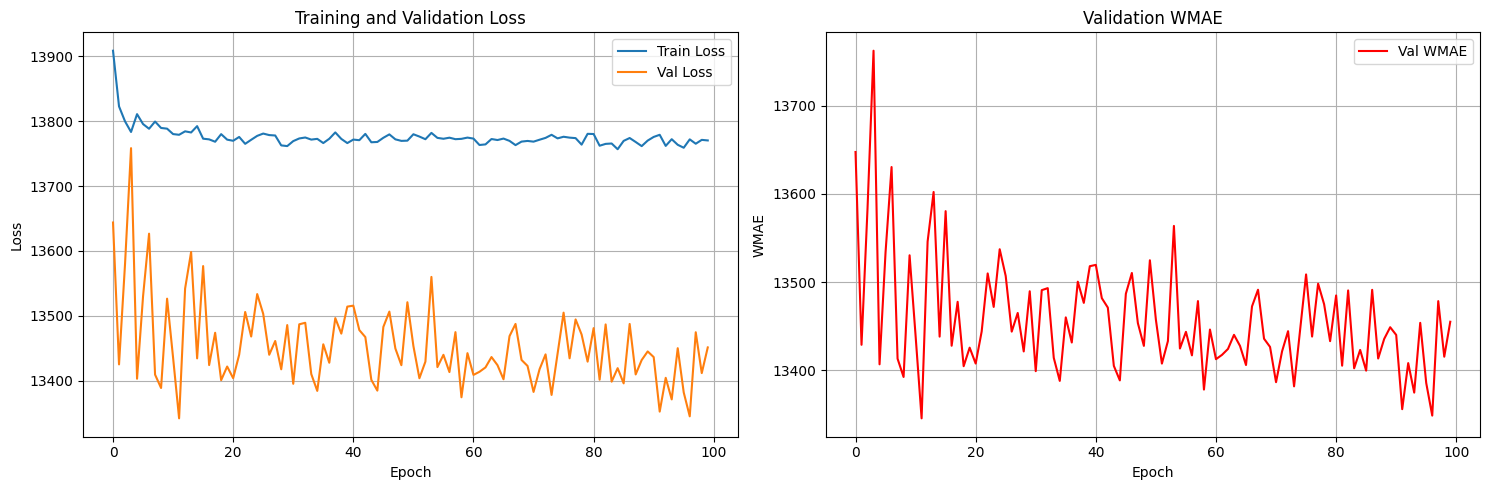

2025/07/06 17:06:11 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/07/06 17:06:20 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpz2u9jap_/model/data, flavor: pytorch), fall back to return ['torch==2.6.0', 'cloudpickle==2.2.1']. Set logging level to DEBUG to see the full traceback.
Registered model 'NBEATS_Walmart_Sales' already exists. Creating a new version of this model...
2025/07/06 17:06:25 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: NBEATS_Walmart_Sales, version 2


MLflow run completed successfully!
Best WMAE: 13345.2305 at epoch 11
Final WMAE: 13454.9121


Created version '2' of model 'NBEATS_Walmart_Sales'.


In [45]:
import mlflow
num_features = train_sequences.shape[-1]
model = NBeatsNet(
    input_size=lookback_window,
    num_features=num_features,
    forecast_size=1,
    stacks=2,
    blocks_per_stack=3,
    layers=4,
    layer_size=512,
    theta_size=32
)

# You can keep your existing ModelTrainer class, but update the model initialization
trainer = ModelTrainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    sales_mean=train_targets.mean(),  # Updated
    sales_std=train_targets.std(),    # Updated
    lr=1e-4,  # Reduced learning rate
    num_epochs=100,  # Increased epochs
    use_wmae_loss=True
)


mlflow.set_experiment("N-BEATS_Training")

with mlflow.start_run(run_name=f"N-BEATS_HyperParameter_Tuning"):

    # TRAIN THE MODEL FIRST - this was missing!
    trainer.train()

    # Now you can use trainer_2.best_wmae and trainer_2.best_epoch
    # which are set by the train() method

    # Log parameters
    mlflow.log_params({
        "lookback_window": lookback_window,
        "epochs": trainer.num_epochs,
        "batch_size": 32,
        "optimizer": "Adam",
        "learning_rate": trainer.lr,
        "use_wmae_loss": True
    })

    # Log metrics
    mlflow.log_metrics({
        "val_wmae_final": trainer.val_wmaes[-1],  # Final epoch
        "val_wmae_best": trainer.best_wmae,       # Best achieved (from train method)
        "best_wmae_epoch": trainer.best_epoch,    # When it occurred (from train method)
        "val_loss_final": trainer.val_losses[-1],
        "train_loss_final": trainer.train_losses[-1]  # Fixed: was epoch_train_losses
    })

    # Log artifacts (assuming you have a plot_losses method)
    plot_path = "loss_plot.png"
    trainer.plot_losses(save_path=plot_path)
    mlflow.log_artifact(plot_path)

    # Log model with metadata
    mlflow.pytorch.log_model(
        trainer.model,
        artifact_path="model",
        registered_model_name="NBEATS_Walmart_Sales"  # Optional model registry
    )

    print(f"MLflow run completed successfully!")
    print(f"Best WMAE: {trainer.best_wmae:.4f} at epoch {trainer.best_epoch}")
    print(f"Final WMAE: {trainer.val_wmaes[-1]:.4f}")